# How to navigate this notebook

This notebook was created in Google Colab, so there are a few command here that allow me to make use of the GPU capabilities on Colab. The 'Setup' section import libraries, definies helper functions, and preprocesses/loads files in usable formats that will allow me to work efficiently. The 'Analysis' section is where all the Machine Learning actually resides. I used two approaches: CNNs (which failed), and Boosted Trees (which succeeded!) that I have described in their respective sections.

I have left some outputs in place where I felt it necessary to show results, while other outputs are hidden to reduce the clutter in the submission. Lastly I have cited online resources that inspired these ideas for audio classification.

# Setup

## Setting up GPU and mounting drive

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub

devices = tf.config.experimental.get_visible_devices()
print("Devices:",devices)
print(tf.config.experimental.list_logical_devices('GPU'))

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from graphviz import Digraph
from IPython.core.display import HTML

!pip install pydub
!apt-get install ffmpeg
!pip install tensorflow_io
!pip install umap-learn
!pip install shap

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Imports, functions, and variables

In [90]:
import os
from matplotlib import pyplot as plt
import seaborn as sns
import umap
import shap
from os import path
from pydub import AudioSegment
import tensorflow_io as tfio
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import librosa
import librosa.display
import IPython.display as ipd
#import tensorflow_io as tfio

In [91]:
def load_wav_mono(filename):
  file_contents = tf.io.read_file(filename)
  # decode wav (tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # remove trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # goes from 4100 to 16000hz - amplitude of te audio signal

  # Can I get this thing to work without this last line?
  # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

def preprocess(file_path, label, size=48000):
  wav = load_wav_mono(file_path)
  wav = wav[3800:3800+size]
  zero_padding = tf.zeros([size] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav],0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

def preprocess_audio(file_path, size=48000):
  wav = load_wav_mono(file_path)
  wav = wav[10000:10000+size]
  zero_padding = tf.zeros([size] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav],0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram


# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

def normalize_spectrogram(image, label):
  image = image/255
  return image, label


def plot_history(training_results):
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Model Loss')
  axs.set_ylabel('loss')
  axs.set_xlabel('number of epochs')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Model Accuracy')
  axs.set_ylabel('accuracy')
  axs.set_xlabel('number of epochs')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

def plot_confusion(confusion_mtx):

  # Create a heatmap of the confusion matrix for visualization
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["0", "1"],
            yticklabels=["0", "1"])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

def make_roc(model, X_val, y_val):
    clf_display = RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.show()

def feature_extraction(file_path):
  # load audio file
  signal, sr = librosa.load(file_path)
  mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=50).T, axis=0)
  return mfcc

def weighted_binary_crossentropy(y_true, y_pred):
    # Convert y_true to float32
    y_true = tf.cast(y_true, dtype=tf.float32)

    # Define class weights
    class_weights = tf.constant([1.0, 5.0], dtype=tf.float32)

    # Use sigmoid cross entropy
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=class_weights)

    # Compute the mean loss
    return tf.reduce_mean(loss)

In [92]:
main_path = "/content/drive/MyDrive/E82/Final_Project/"
wav_path = "/content/drive/MyDrive/E82/Final_Project/wavs"
clips_path = "/content/drive/MyDrive/E82/Final_Project/clips"
meta_path = "/content/drive/MyDrive/E82/Final_Project/metadata"

Load saved objects

In [93]:
# FOR XGB CLASSIFIER (SUCCESS)

mfcc_meta = pd.read_csv(
    os.path.join(meta_path, 'cc_all_meta.csv')
)

xgb_clf = xgb.XGBClassifier()
xgb_clf.load_model(
    os.path.join(main_path, 'xgboost_classifier.json')
)

In [94]:
# FOR CNN (FAILED ATTEMPT)
metadata = pd.read_csv(os.path.join(meta_path, 'filtered_meta.csv'))

metadata.dropna(subset='gender', inplace=True)
metadata = metadata[metadata['gender'].isin(['male','female'])]
metadata['gender_binary'] = np.where(metadata['gender'] == 'male', 0.0, 1.0)
metadata['full_path'] = metadata['wav_path'].apply(lambda x: os.path.join(wav_path, x))
wav_paths = metadata['full_path'].tolist()
genders = metadata['gender_binary'].tolist()

dataset = tf.data.Dataset.from_tensor_slices((wav_paths, genders))
gender_tf = tf.data.Dataset.from_tensor_slices(genders)
audio_tf = tf.data.Dataset.from_tensor_slices(wav_paths)

In [95]:
# validatated audios only
# validated = pd.read_csv(os.path.join(meta_path, 'validated.tsv'), sep='\t')
#invalidated = pd.read_csv(os.path.join(meta_path, 'invalidated.tsv'), sep='\t')
#other = pd.read_csv(os.path.join(meta_path, 'other.tsv'), sep='\t')

# metadata.dropna(subset='gender', inplace=True)
# metadata = metadata[metadata['gender'].isin(['male','female'])]
# metadata['gender_binary'] = np.where(metadata['gender'] == 'male', 0.0, 1.0)
# metadata['full_path'] = metadata['wav_path'].apply(lambda x: os.path.join(wav_path, x))
# wav_paths = metadata['full_path'].tolist()
# genders = metadata['gender_binary'].tolist()
# metadata = metadata[metadata['path'].isin(validated['path'])]
# dataset = tf.data.Dataset.from_tensor_slices((wav_paths, genders))
# gender_tf = tf.data.Dataset.from_tensor_slices(genders)
# audio_tf = tf.data.Dataset.from_tensor_slices(wav_paths)

# mfcc_meta = pd.read_csv(
#     os.path.join(meta_path, 'cc_validated_meta.csv', index_col=0)
# )

## File preprocessing (skip if already done)

Curating metadata

In [ ]:
#reported = pd.read_csv(os.path.join(meta_path, 'reported.tsv'), sep='\t') broken
validated = pd.read_csv(os.path.join(meta_path, 'validated.tsv'), sep='\t')
invalidated = pd.read_csv(os.path.join(meta_path, 'invalidated.tsv'), sep='\t')
other = pd.read_csv(os.path.join(meta_path, 'other.tsv'), sep='\t')

validated['source'] = 'validated'
invalidated['source'] = 'invalidated'
other['source'] = 'other'
metadata = pd.concat([validated, invalidated, other])

metadata['wav_path'] = metadata['path'].apply(lambda x: x[:-3] + 'wav')
metadata_filtered = metadata[metadata['wav_path'].isin(os.listdir(wav_path))]
metadata_filtered.to_csv(os.path.join(meta_path, 'filtered_meta.csv'))

Convert .mp3 into .wav format

In [ ]:
# takes a while, converted ~22,500 files which I think is enough
files = os.listdir(clips_path)
for mp3 in files:
  wav_name = mp3[:-3] + 'wav'
  wav_dst = os.path.join(wav_path, wav_name)
  mp3_path = os.path.join(clips_path, mp3)
  sound = AudioSegment.from_mp3(mp3_path)
  sound.export(wav_dst, format="wav")

# Analysis

## CNN Approach (FAILED)

In this approach I tried to convert every audio file into a spectrogram image to then be inputted into a CNN. This proved to be overly clunky for my resources as the spectrograms were only of mediocre quality and too large to use the proper Neural Network architecture that audio classification deserves. I enjoyed learning about this technique, but I found Mel Frequency Cepstrum Coefficients (MFCC) to be a stronger and faster technique.

For this idea I was inspired by Nicholas Renotte who wrote this excellent Github repo that can be found here: https://github.com/nicknochnack/DeepAudioClassification

### Example plots

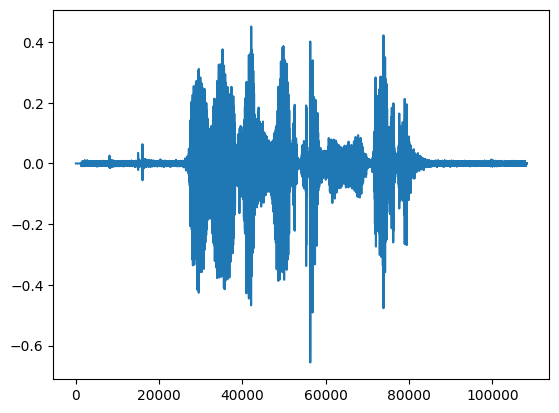

In [105]:
# Example waveform plot
wav = load_wav_mono(
    os.path.join(wav_path, 'common_voice_en_34931599.wav')
)
plt.plot(wav)

Note that the function to preprocess spectrograms has to make sure every audio file is the same length, therefore each files is clipped to only be 48000 samples long. I removed the beginning of each audio file because there is usually a little bit of silence at the beginning and I wanted to capture as much speaking as possible.

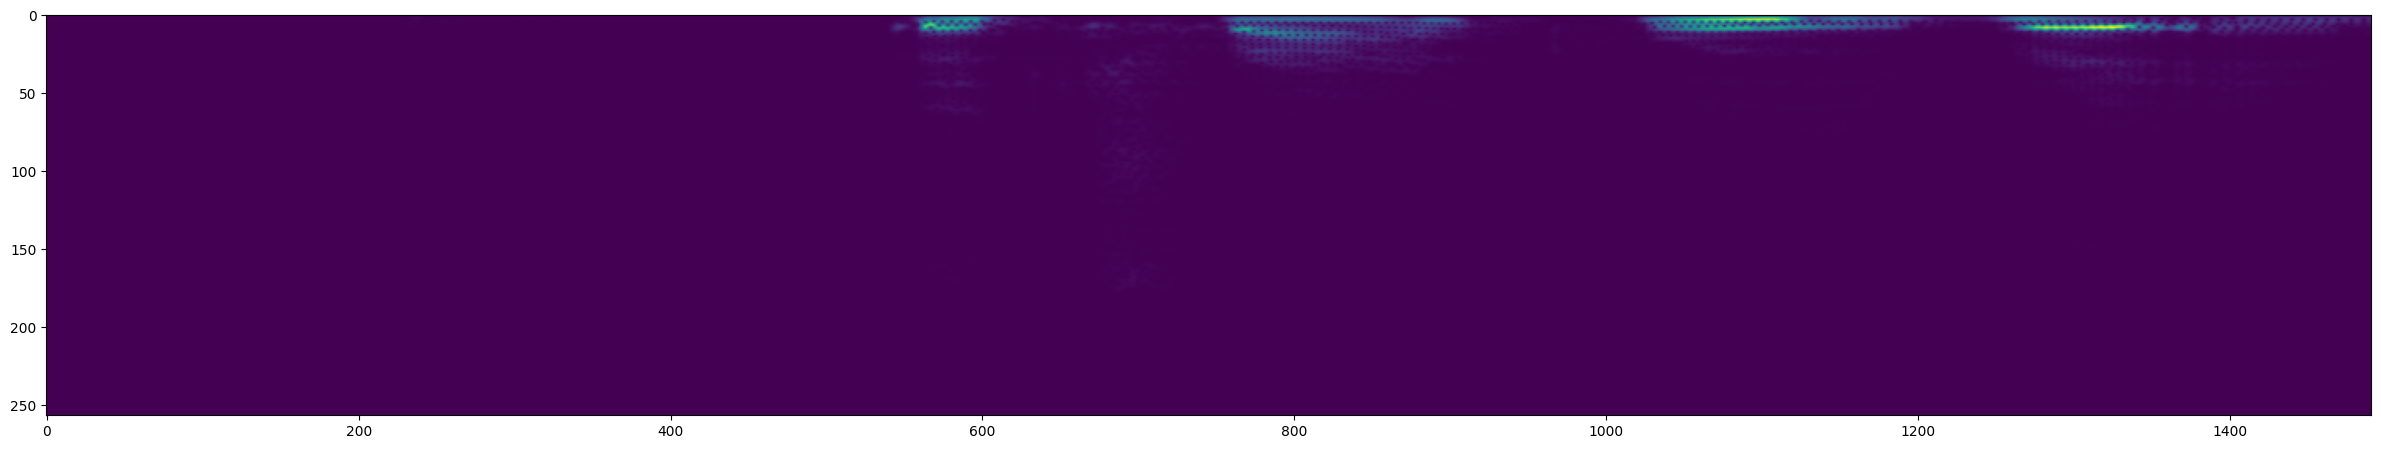

In [104]:
# Example spectrogram
filepath, label = ('/content/drive/MyDrive/E82/Final_Project/wavs/common_voice_en_35328182.wav', 1)
spectrogram, label = preprocess(filepath, label)
spectrogram, label = normalize(spectrogram, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### CNN

In [ ]:
#small_dataset = dataset.take(5000)
#data = small_dataset.map(preprocess)
data = dataset.map(preprocess)
data = data.map(normalize)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Originally, I was going to start out just building the pipeline on a small portion of the data and expand later. I realized that it was impossible to expand with my current computing resources because there is too much spectrogram data to process

In [ ]:
# take first 280 batches to train
# validate on 32
# This only uses about 1/4 of the complete dataset
train = data.take(280)
test = data.skip(280).take(32)

In [ ]:
# this tells us the input shape we need for the CNN but it slow to run, so below I hard coded (1491, 257, 1)
# samples, labels = train.as_numpy_iterator().next()
# samples.shape

It is impossible to use a more complex archtecture in google colab... I would have to overly limit the size of my spectrograms

In [ ]:
# input shape hard-coded but we coulc replace with `samples.shape[1:]`

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(layers.MaxPooling2D((2,2)))

# COULD TRY MORE MAX POOLING LAYERS WITH CONV LAYERS
#model.add(layers.Conv2D(filters=16, kernel_size=(5, 5),
#                          padding='same', activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

I acknowledged that the dataset wasn't perfectly balanced (3 times as many male voices as female), so I created a custom loss function called "weighted_binary_crossentropy" that penalized misclassifier female voices more than male voices. It didn't work, but it was cool to see how you could customize the loss function in TensorFlow

In [ ]:
loss = losses.categorical_crossentropy
learning_rate=0.01
optimizer = optimizers.Adam(learning_rate=learning_rate)


model.compile(loss=weighted_binary_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
#hist = model.fit(train, epochs=4, validation_data=test)
training_results = model.fit(train,
                              validation_data=test,
                              batch_size=512,
                              epochs=10,
                              verbose=1)

In [ ]:
plot_history(training_results)

I tried many different small variations such as changing the learning rate, the training size, the batch size, and the loss function but I was not making much progress so I switched to the Cepstrum Coefficient approach suggested by Professor Henstock.

In [ ]:
# SAVE AND DOCUMENT FOR LATER

#model.save(os.path.join(main_path, 'progress_model.h5'))

# need to save the model as well
# pd.concat([running_history, training_results.history], axis=0)
# running_history = pd.DataFrame(training_results.history)
# training_history_path = os.path.join(main_path, 'weighted_training_history.csv')
# running_history.to_csv(training_history_path)
# model.save(os.path.join(main_path, 'weighted_model.h5'))

# MAKE PREDICTIONS - DIAGNOSE THE ISSUE
# ok I can make predictions with this, but how do I get the true labels?
# X_test, y_test = test.as_numpy_iterator().next()
# yhat = model_.predict(data.take(500))
# predictions = [1 if y > 0.5, else 0 for y in yhat]

## MFCC and XGBoost approach

In this section I just transformed every audio file into a 1-D, 50 dimensional feature vector using the MFCC transformation provided by librosa. Then I inputted the audio vectors into a XGBoosted Tree to classify the audio files based on gender.

In general, the transformation returns Cepstrum coefficients many time intervals, but to simplify the analysis I just averaged them to get a single vector per audio files. I found this strategy to be pretty standard, and it worked really well here!

### Extracting MFCC features from the wav files

I had to look up how to perform the MFCC feature extraction from this Github page: https://github.com/musikalkemist/AudioSignalProcessingForML/blob/master/20-%20Extracting%20MFCCs%20with%20Python/Extracting%20MFCCs.ipynb written by Valerio Velardo

In [ ]:
test_wav = os.path.join(wav_path, 'common_voice_en_34931599.wav')
ipd.Audio(test_wav)

Compute MFCC for each wave file (SKIP IF ALREADY DONE!)

In [17]:
# save the mfcc from each wav file
mfcc_df = pd.DataFrame()
columns = [f'CC_{x}' for x in range(50)]
cc_meta_path = os.path.join(meta_path, 'cc_all_meta.csv')
counter = 0

for filename in metadata['wav_path']:
  try:
    file_path = os.path.join(wav_path, filename)
    mfcc = feature_extraction(file_path)
    temp_df = pd.DataFrame(mfcc).T
    temp_df.columns = columns
    temp_df.index = [filename]
    mfcc_df = pd.concat([mfcc_df, temp_df])
    counter += 1
    if (counter % 200) == 0:
      mfcc_df.to_csv(cc_meta_path)
  except:
    pass

# save
mfcc_df.to_csv(cc_meta_path)

In [21]:
# merge with metadata
mfcc_df['wav_path'] = mfcc_df.index
mfcc_meta = pd.merge(metadata, mfcc_df, on='wav_path')

In [22]:
mfcc_meta.to_csv(
    os.path.join(meta_path, 'cc_all_meta.csv')
)

### Plotting UMAP

I just wanted to plot the UMAP of the data to see if this approach was feasible or if the MFCC data was going to be too low-quality.

In [38]:
columns = [f'CC_{x}' for x in range(50)]
df = mfcc_meta[columns]

# Instantiate the UMAP model with desired parameters
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_result = umap_model.fit_transform(df)

# Create a new DataFrame with the UMAP result
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df = pd.concat([umap_df, metadata[['gender']]], axis=1)

The genders clump enough to give me hope that we can classify the audio files!

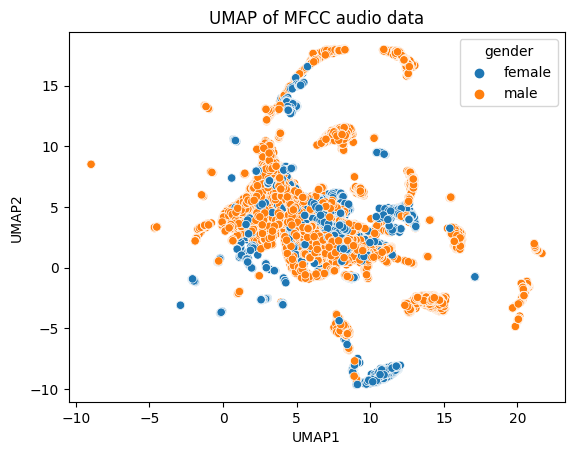

In [39]:
sns.scatterplot(umap_df, x='UMAP1', y='UMAP2', hue='gender')
plt.title('UMAP of MFCC audio data')
plt.show()

In [40]:
#Grid Search
# I set the scale_pos_weight to 3 because there are more males and than female
param_grid = {"max_depth":[6, 7, 8],
          'learning_rate': [0.1, 0.05],
          'scale_pos_weight': [3],
          'gamma': [0, 0.5, 1.0],
          'reg_alpha': [0.5, 1.0, 0],
          'reg_lambda': [0.5, 1.0, 0],
          'colsample_by_tree': [0.85],
        'n_estimators':[50]
}

In [98]:
X = mfcc_meta[columns]
y = mfcc_meta[['gender_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [42]:
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=23, n_jobs=-1)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=23, ...),
             n_jobs=-1,
             param_grid={'colsample_by_tree': [0.85], 'gamma': [0, 0.5, 1.0],
                         'learning_rate': [0.1, 0.05], 'max_depth': [6, 7, 8],
                         'n_estimators': [50], 'reg_alpha': [0.5, 1.0, 0],
                         'reg_lambda': [0.5, 1.0, 0], 'scale_pos_weight': [3]},
             scoring='roc_auc')

As you can see, several possible hyperparameters work, so the this classification is actually prety robust.

In [43]:
# change which columns are showing
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score',ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_by_tree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
132,3.648088,0.117984,0.026829,0.004096,0.85,1.0,0.1,8,50,0,...,0.996825,0.996269,0.998499,0.998236,0.998490,0.998123,0.997498,0.997636,0.000718,1
74,3.590590,0.049410,0.025008,0.001500,0.85,0.5,0.1,8,50,0.5,...,0.996558,0.996514,0.998350,0.998317,0.998061,0.998240,0.997421,0.997605,0.000686,2
80,3.668834,0.136144,0.024633,0.001728,0.85,0.5,0.1,8,50,0,...,0.996661,0.996527,0.998033,0.998193,0.998319,0.998276,0.997409,0.997605,0.000684,3
133,3.832599,0.131948,0.024904,0.001995,0.85,1.0,0.1,8,50,0,...,0.996624,0.995894,0.998141,0.998244,0.998389,0.998261,0.997729,0.997596,0.000779,4
75,3.816295,0.122940,0.027133,0.006302,0.85,0.5,0.1,8,50,1.0,...,0.996773,0.996192,0.997927,0.998201,0.998332,0.998342,0.997364,0.997566,0.000722,5


From the optimal parameters below, the model likes to have a fair bit of regularization. Glad we checked!

In [44]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params

{'colsample_by_tree': 0.85,
 'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 50,
 'reg_alpha': 0,
 'reg_lambda': 0.5,
 'scale_pos_weight': 3}

In [50]:
best_model.save_model(
    os.path.join(main_path, 'xgboost_classifier.json')
)

In [56]:
xgb_clf = best_model

In [100]:
pred_out = xgb_clf.predict(X_test)
pred_in = xgb_clf.predict(X_train)

confuse_out = confusion_matrix(y_test, pred_out)
confuse_in = confusion_matrix(y_train, pred_in)

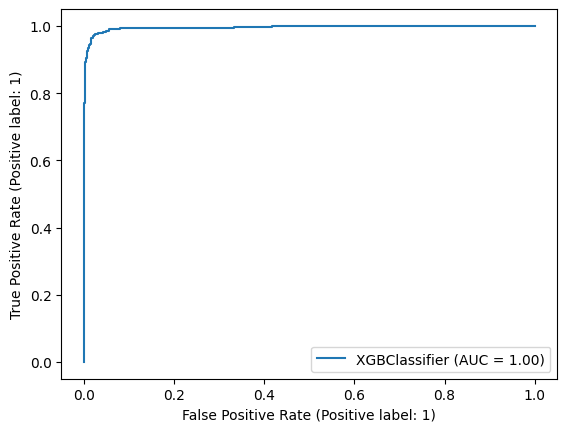

In [101]:
make_roc(best_model, X_test, y_test)

The labels have been 1-hot encoded such that 0s are Males, and 1's are Females

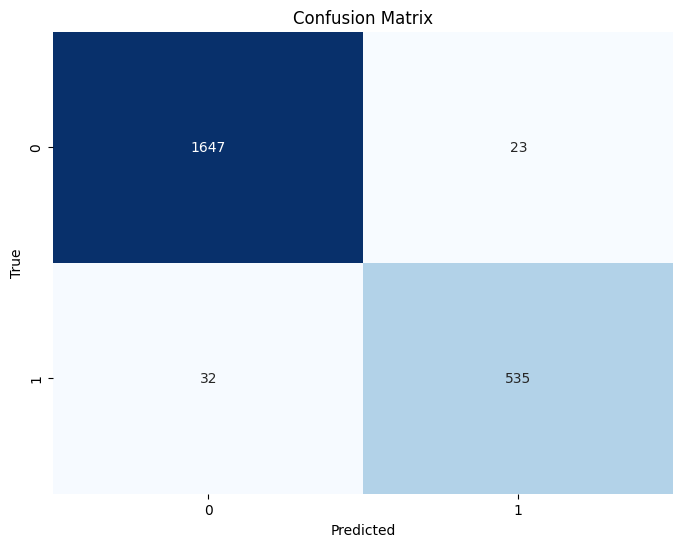

In [102]:
# 0 = 'Male'
# 1 = 'Female'
plot_confusion(confuse_out)

### SHAP and Explainable AI

In [55]:
shap.initjs()

In [57]:
explainer = shap.TreeExplainer(xgb_clf)
feature_names = xgb_clf.get_booster().feature_names

In [70]:
shap_values = explainer.shap_values(X_train)
shap_values = pd.DataFrame(shap_values,
                           columns = [f'CC_{x}' for x in range(50)])

# Extract the top features
rank = shap_values.T
rank['avg_abs'] = rank.abs().mean(axis=1)
rank.sort_values('avg_abs', inplace = True, ascending=False)
ranked_features = rank.index

Interestingly the CC_33 and CC15 coefficients are the most important! I initially expected the lower order coefficients to be the dominant ones.

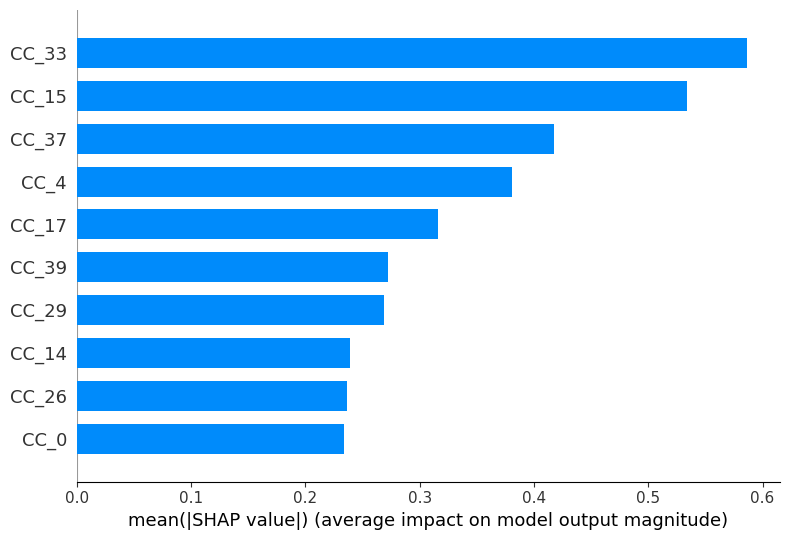

In [66]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)

The way that the model output partitions the red and blue data points is indicative of an important feature!

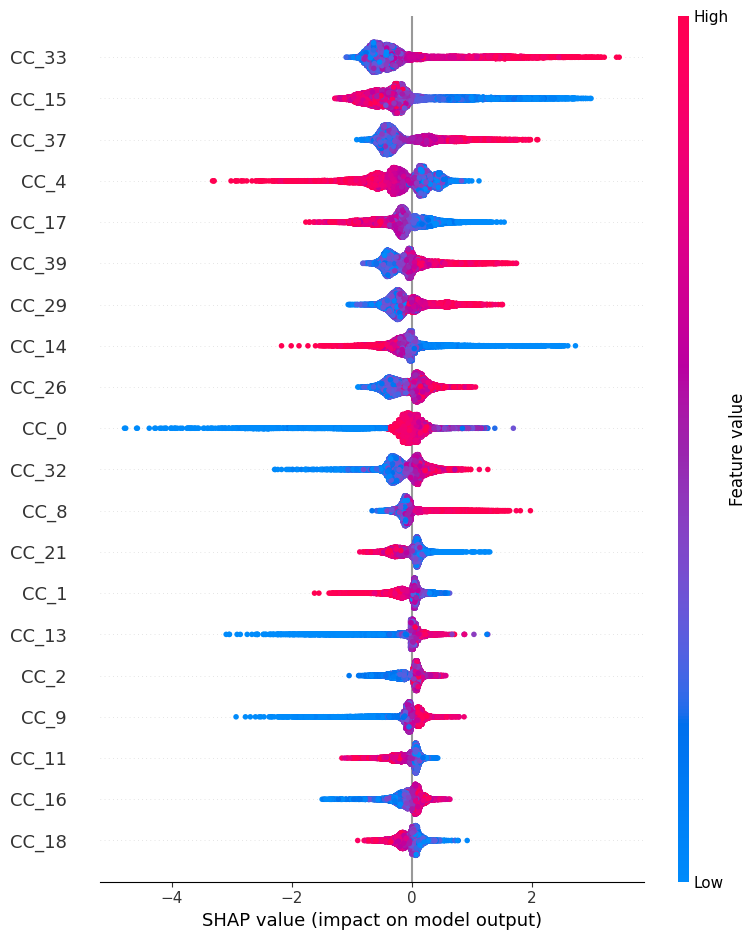

In [86]:
shap.summary_plot(shap_values.loc[:, ranked_features[:20]].to_numpy(),
                  X_train.loc[:, ranked_features[:20]].to_numpy(),
                 feature_names=ranked_features[:20])